In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 66.1 MB/s eta 0:00:00


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data as Data
import torch.nn as nn
from timm.data import rand_augment_transform
from torchvision.transforms import RandomErasing, ToTensor, Normalize
import random
import numpy as np
from PIL import Image

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


In [4]:
#Constants
batch_size = 128
patch_size = 4
attention_heads = 8
embed_dim = 256
transformer_blocks = 6
MLP_nodes = 512
num_classes = 10
num_channels = 3
img_size = 32
patch_num = (img_size // patch_size) ** 2
drop_rate = 0.1
lr = 0.0003
w_d = 0.05
mixup_prob = 0.8
cutmix_prob = 0.8

In [5]:
train_data =Data.DataLoader(trainset,shuffle=True,batch_size= batch_size,num_workers=2)
test_data =Data.DataLoader(testset,shuffle=True,batch_size= batch_size,num_workers=2)

In [6]:
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed = nn.Conv2d(num_channels,embed_dim,kernel_size = patch_size, stride = patch_size)
  def forward(self,x):
    x = self.patch_embed(x)
    x = x.flatten(2)
    x = x.transpose(1,2)
    return x

In [7]:
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embed_dim)
    self.multihead_attention = nn.MultiheadAttention(embed_dim,attention_heads, batch_first= True)
    self.dropout1 = nn.Dropout(drop_rate) # Add dropout after attention
    self.layer_norm2 = nn.LayerNorm(embed_dim)
    self.MLP = nn.Sequential(
        nn.Linear(embed_dim,MLP_nodes),
        nn.GELU(),
        nn.Dropout(drop_rate), # Add dropout after first linear layer
        nn.Linear(MLP_nodes,embed_dim)
    )
    self.dropout2 = nn.Dropout(drop_rate) # Add dropout after MLP
  def forward(self,x):
    residual1 = x
    x = self.layer_norm1(x)
    x = self.multihead_attention(x,x,x)[0]
    x = self.dropout1(x) # Apply dropout
    x = residual1 + x
    residual2 = x
    x = self.layer_norm2(x)
    x = self.MLP(x)
    x = self.dropout2(x) # Apply dropout
    x = residual2 + x
    return x

In [8]:
class MLP_head(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embed_dim)
    self.mlphead = nn.Sequential(
        # nn.LayerNorm(embed_dim),
        nn.Linear(embed_dim,num_classes)
    )
  def forward(self,x):
    x = self.mlphead(x)
    return x

In [9]:
class transformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
    self.position_embedding = nn.Parameter(torch.randn(1,(img_size // patch_size) ** 2 + 1,embed_dim))
    self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)])
    self.MLP_head = MLP_head()
  def forward(self,x):
    x = self.patch_embedding(x)
    cls_token = self.cls_token.expand(x.shape[0],-1,-1)
    x = torch.cat((cls_token,x),dim = 1)
    x = x + self.position_embedding
    x = self.transformer_blocks(x)
    x = x[:,0]
    x = self.MLP_head(x)
    return x

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 35
model2 = transformer().to(device)
optimizer = torch.optim.AdamW(model2.parameters(),lr = lr,weight_decay=w_d)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

In [14]:
def apply_mixup(images, labels, alpha):
    """Applies Mixup data augmentation to a batch of images and labels."""
    batch_size = images.size(0)
    lam = np.random.beta(alpha, alpha)
    lam = max(lam, 1 - lam) # Ensure lambda is between 0.5 and 1

    index = torch.randperm(batch_size)

    mixed_images = lam * images + (1 - lam) * images[index, :]

    # Mixup labels (one-hot encoding)
    one_hot_labels = F.one_hot(labels, num_classes).float()
    mixed_labels = lam * one_hot_labels + (1 - lam) * one_hot_labels[index, :]

    return mixed_images, mixed_labels

In [13]:
ra_params = dict(
    translate_const=4,
    img_mean=(0, 0, 0),
)
rand_aug = rand_augment_transform('rand-m9-n2-mstd0.5', ra_params)

normalize = transforms.Normalize(
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.247, 0.243, 0.261)
)

In [12]:
def apply_cutmix(images, labels, alpha):

    batch_size, _, img_h, img_w = images.size()
    lam = np.random.beta(alpha, alpha)
    lam = max(lam, 1 - lam) # Ensure lambda is between 0.5 and 1

    index = torch.randperm(batch_size)

    # Calculate bounding box coordinates
    cut_ratio = np.sqrt(1.0 - lam)
    cut_w = int(img_w * cut_ratio)
    cut_h = int(img_h * cut_ratio)

    cx = np.random.randint(img_w)
    cy = np.random.randint(img_h)

    bbx1 = np.clip(cx - cut_w // 2, 0, img_w)
    bby1 = np.clip(cy - cut_h // 2, 0, img_h)
    bbx2 = np.clip(cx + cut_w // 2, 0, img_w)
    bby2 = np.clip(cy + cut_h // 2, 0, img_h)

    # Create mask
    mask = torch.zeros_like(images)
    mask[:, :, bby1:bby2, bbx1:bbx2] = 1

    # Apply CutMix
    cutmix_images = images * (1 - mask) + images[index, :] * mask

    # Adjust lambda based on the actual area of the bounding box
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img_w * img_h))

    # Mixup labels (one-hot encoding)
    one_hot_labels = F.one_hot(labels, num_classes).float()
    mixed_labels = lam * one_hot_labels + (1 - lam) * one_hot_labels[index, :]

    return cutmix_images, mixed_labels

In [11]:
from torchvision.transforms import RandomErasing

def random_erasing(images, p):

    if random.random() < p:
      # Apply Random Erasing to each image in the batch
      for i in range(images.size(0)):
        images[i] = RandomErasing(scale=(0.02, 0.33), ratio=(0.3, 3.3))(images[i])
    return images

In [15]:
from torch.optim.lr_scheduler import LambdaLR
import math

def cosine_annealing_with_warmup(current_step, warmup_steps, total_steps):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    elif current_step >= total_steps:
        return 0.0
    else:
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))



In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = transformer().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr = lr,weight_decay=w_d)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

In [16]:
epochs = 30
warmup_epochs = 4
steps_per_epoch = len(train_data)      # number of batches
total_steps = epochs * steps_per_epoch
warmup_steps = warmup_epochs * steps_per_epoch

scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda step: cosine_annealing_with_warmup(step, warmup_steps, total_steps)
)

In [17]:
best_val_acc = 0.0
best_epoch = -1

# Arrays for plotting
train_acc_history = []
val_acc_history = []
loss_history = []

for epoch in range(epochs):
    model2.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"\nEpoch {epoch+1}")


    # Training loop

    for batch_idx, (images, labels) in enumerate(train_data):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(images)

        loss = loss_fn(outputs, labels)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()
        correct_epoch += correct
        total_epoch += labels.size(0)

        if batch_idx % 100 == 0:
            accuracy = 100.0 * correct / images.size(0)
            print(f"  Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")
            current_lr = optimizer.param_groups[0]['lr']
            print(f"  Current Learning Rate: {current_lr:.6f}")

    train_acc = 100.0 * correct_epoch / total_epoch
    avg_loss = total_loss / len(train_data)
    print(f"==> Epoch {epoch+1} Summary: Avg Loss = {avg_loss:.4f}, Train Accuracy = {train_acc:.2f}%")

    # Validation loop
    model2.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in test_data:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100.0 * val_correct / val_total
    print(f"==> Validation Accuracy after Epoch {epoch+1}: {val_acc:.2f}%")

    # Track best epoch
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model2.state_dict(), "best_vit_model.pth")
        print(f"New Best Model at Epoch {best_epoch}! Saved with Val Acc = {best_val_acc:.2f}%")

    # Save values for plotting
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    loss_history.append(avg_loss)

print(f"\n Best Validation Accuracy: {best_val_acc:.2f}% at Epoch {best_epoch}")



Epoch 1
  Batch   1: Loss = 2.7726, Accuracy = 8.59%
  Current Learning Rate: 0.000000
  Batch 101: Loss = 2.2395, Accuracy = 14.06%
  Current Learning Rate: 0.000019
  Batch 201: Loss = 2.1313, Accuracy = 21.09%
  Current Learning Rate: 0.000039
  Batch 301: Loss = 1.9561, Accuracy = 31.25%
  Current Learning Rate: 0.000058
==> Epoch 1 Summary: Avg Loss = 2.1483, Train Accuracy = 23.88%
==> Validation Accuracy after Epoch 1: 35.30%
New Best Model at Epoch 1! Saved with Val Acc = 35.30%

Epoch 2
  Batch   1: Loss = 1.7918, Accuracy = 44.53%
  Current Learning Rate: 0.000075
  Batch 101: Loss = 1.7757, Accuracy = 46.09%
  Current Learning Rate: 0.000094
  Batch 201: Loss = 1.7697, Accuracy = 38.28%
  Current Learning Rate: 0.000114
  Batch 301: Loss = 1.7578, Accuracy = 39.06%
  Current Learning Rate: 0.000133
==> Epoch 2 Summary: Avg Loss = 1.7928, Train Accuracy = 41.00%
==> Validation Accuracy after Epoch 2: 46.15%
New Best Model at Epoch 2! Saved with Val Acc = 46.15%

Epoch 3
  Ba

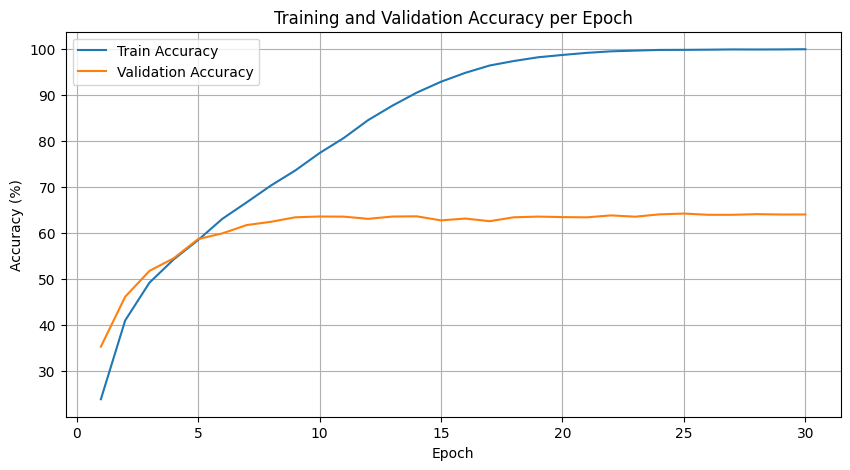

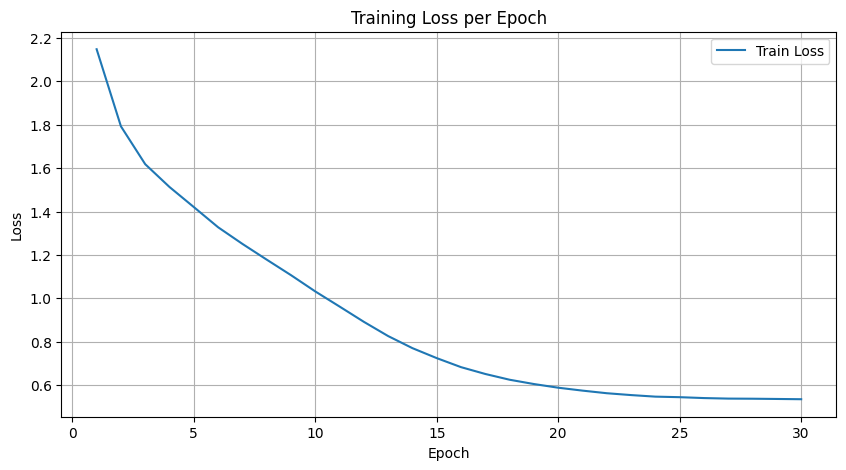

In [18]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_history, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
epochs = 30
warmup_epochs = 4
steps_per_epoch = len(train_data)      # number of batches
total_steps = epochs * steps_per_epoch
warmup_steps = warmup_epochs * steps_per_epoch

scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda step: cosine_annealing_with_warmup(step, warmup_steps, total_steps)
)

In [22]:
best_val_acc = 0.0
best_epoch = -1

# Arrays for plotting later
train_losses = []
train_accuracies = []
val_accuracies = []
model = transformer().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr = lr,weight_decay=w_d)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
for epoch in range(epochs):
  model.train()
  total_loss = 0
  correct_epoch = 0
  total_epoch = 0
  print(f"\nEpoch {epoch+1}")

  # Training loop
  for batch_idx, (images, labels) in enumerate(train_data):
      # Apply augmentations
      if random.random() < mixup_prob:
          images, labels = apply_mixup(images, labels, alpha=0.2)
      elif random.random() < cutmix_prob:
          images, labels = apply_cutmix(images, labels, alpha=1.0)
      images = random_erasing(images, p=0.3)

      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)

      loss = loss_fn(outputs, labels)
      loss.backward()

      # Gradient Clipping
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

      optimizer.step()
      scheduler.step()

      total_loss += loss.item()

      # Handle mixup/cutmix (soft labels) vs normal labels
      if labels.ndim > 1:
          preds = outputs.argmax(dim=1)
          _, target_labels = labels.max(dim=1)
          correct = (preds == target_labels).sum().item()
      else:
          preds = outputs.argmax(dim=1)
          correct = (preds == labels).sum().item()

      accuracy = 100.0 * correct / images.size(0)
      correct_epoch += correct
      total_epoch += images.size(0)

      if batch_idx % 100 == 0:
          print(f"  Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")
          current_lr = optimizer.param_groups[0]['lr']
          print(f"  Current Learning Rate: {current_lr:.6f}")

  train_acc = 100.0 * correct_epoch / total_epoch
  avg_loss = total_loss / len(train_data)
  print(f"==> Epoch {epoch+1} Summary: Total Loss = {avg_loss:.4f}, Train Accuracy = {train_acc:.2f}%")

  # Store training stats
  train_losses.append(avg_loss)
  train_accuracies.append(train_acc)

  # Validation loop
  model.eval()
  val_correct, val_total = 0, 0
  with torch.no_grad():
      for images, labels in test_data:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          preds = outputs.argmax(dim=1)
          val_correct += (preds == labels).sum().item()
          val_total += labels.size(0)

  val_acc = 100.0 * val_correct / val_total
  val_accuracies.append(val_acc)
  print(f"==> Validation Accuracy after Epoch {epoch+1}: {val_acc:.2f}%")
  # Track best epoch
  if val_acc > best_val_acc:
      best_val_acc = val_acc
      best_epoch = epoch + 1
      torch.save(model.state_dict(), f"best_vit_model_patch size:{patch_size}_embedding size:{embed_dim}_attention heads:{attention_heads}_Blocks:{transformer_blocks}_MLP nodes:{MLP_nodes}")
      print(f" New Best Model at Epoch {best_epoch}! Saved with Val Acc = {best_val_acc:.2f}%")



Epoch 1


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  Batch   1: Loss = 2.6516, Accuracy = 10.94%
  Current Learning Rate: 0.000300
  Batch 101: Loss = 2.0546, Accuracy = 33.59%
  Current Learning Rate: 0.000300
  Batch 201: Loss = 1.8205, Accuracy = 35.16%
  Current Learning Rate: 0.000300
  Batch 301: Loss = 1.9767, Accuracy = 39.06%
  Current Learning Rate: 0.000300
==> Epoch 1 Summary: Total Loss = 1.9840, Train Accuracy = 33.39%
==> Validation Accuracy after Epoch 1: 47.45%
🌟 New Best Model at Epoch 1! Saved with Val Acc = 47.45%

Epoch 2
  Batch   1: Loss = 1.7815, Accuracy = 42.97%
  Current Learning Rate: 0.000300
  Batch 101: Loss = 1.6206, Accuracy = 53.91%
  Current Learning Rate: 0.000300
  Batch 201: Loss = 1.8502, Accuracy = 39.06%
  Current Learning Rate: 0.000300
  Batch 301: Loss = 1.8862, Accuracy = 38.28%
  Current Learning Rate: 0.000300
==> Epoch 2 Summary: Total Loss = 1.7696, Train Accuracy = 45.92%
==> Validation Accuracy after Epoch 2: 52.62%
🌟 New Best Model at Epoch 2! Saved with Val Acc = 52.62%

Epoch 3
  Ba

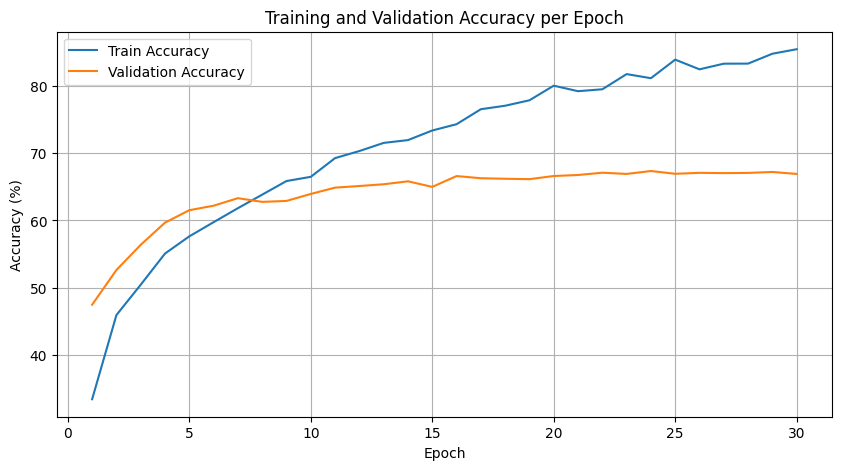

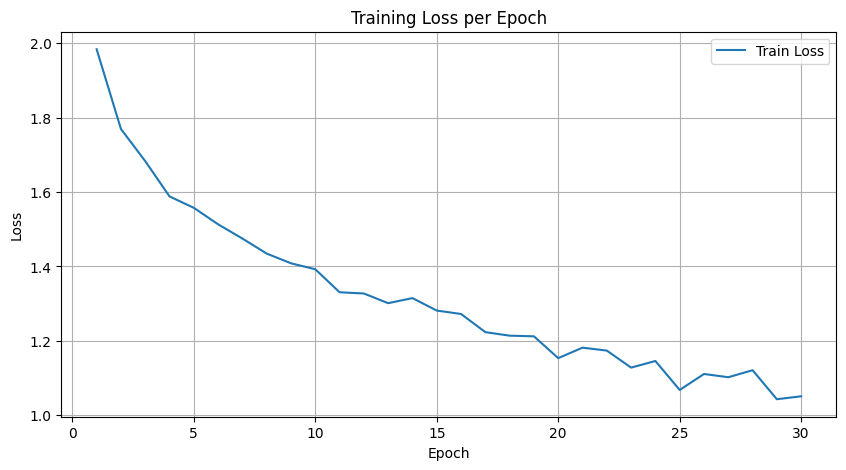

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

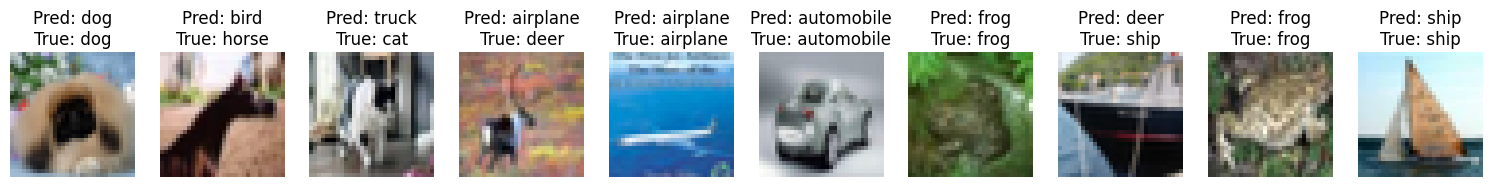

In [27]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def show_predictions(model, test_data, device, num_images=4):
    model.eval()
    images, labels = next(iter(test_data))  # take one batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)

    # plot first few images
    plt.figure(figsize=(19, 4))
    for i in range(num_images):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # normalize for display

        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")

    plt.show()
show_predictions(model, test_data, device, 10)

The cell below can be used for hyperparameter tuning if wanted.

In [ ]:
for patch_size in [2, 4, 8, 16]:
  for embed_dim in [32, 64, 128, 256]:
    for attention_heads in [2, 4, 8, 16]:
      for transformer_blocks in [2, 4, 6, 8]:
        for MLP_nodes in [32, 64, 128, 256]:
          stride_size = patch_size
          patch_num = (img_size // patch_size) ** 2
          class PatchEmbedding(nn.Module):
            def __init__(self):
              super().__init__()
              self.patch_embed = nn.Conv2d(num_channels,embed_dim,kernel_size = patch_size, stride = stride_size)
            def forward(self,x):
              x = self.patch_embed(x)
              x = x.flatten(2)
              x = x.transpose(1,2)
              return x
          class TransformerEncoder(nn.Module):
            def __init__(self):
              super().__init__()
              self.layer_norm1 = nn.LayerNorm(embed_dim)
              self.multihead_attention = nn.MultiheadAttention(embed_dim,attention_heads, batch_first= True)
              self.layer_norm2 = nn.LayerNorm(embed_dim)
              self.MLP = nn.Sequential(
                  nn.Linear(embed_dim,MLP_nodes),
                  nn.GELU(),
                  nn.Linear(MLP_nodes,embed_dim)
              )
            def forward(self,x):
              residual1 = x
              x = self.layer_norm1(x)
              x = self.multihead_attention(x,x,x)[0]
              x = residual1 + x
              residual2 = x
              x = self.layer_norm2(x)
              x = self.MLP(x)
              x = residual2 + x
              return x
          class MLP_head(nn.Module):
            def __init__(self):
              super().__init__()
              self.layer_norm1 = nn.LayerNorm(embed_dim)
              self.mlphead = nn.Sequential(
                  # nn.LayerNorm(embed_dim),
                  nn.Linear(embed_dim,num_classes)
              )
            def forward(self,x):
              x = self.mlphead(x)
              return x
          class transformer(nn.Module):
            def __init__(self):
              super().__init__()
              self.patch_embedding = PatchEmbedding()
              self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
              self.position_embedding = nn.Parameter(torch.randn(1,(img_size // patch_size) ** 2 + 1,embed_dim))
              self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)])
              self.MLP_head = MLP_head()
            def forward(self,x):
              x = self.patch_embedding(x)
              cls_token = self.cls_token.expand(x.shape[0],-1,-1)
              x = torch.cat((cls_token,x),dim = 1)
              x = x + self.position_embedding
              x = self.transformer_blocks(x)
              x = x[:,0]
              x = self.MLP_head(x)
              return x
          best_val_acc = 0.0
          best_epoch = -1

          # Arrays for plotting later
          train_losses = []
          train_accuracies = []
          val_accuracies = []
          model = transformer().to(device)
          optimizer = torch.optim.AdamW(model.parameters(),lr = lr,weight_decay=w_d)
          loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
          for epoch in range(epochs):
              model.train()
              total_loss = 0
              correct_epoch = 0
              total_epoch = 0
              print(f"\nEpoch {epoch+1}")

              # -----------------------
              # Training loop
              # -----------------------
              for batch_idx, (images, labels) in enumerate(train_data):
                  # Apply augmentations
                  if random.random() < mixup_prob:
                      images, labels = apply_mixup(images, labels, alpha=0.2)
                  elif random.random() < cutmix_prob:
                      images, labels = apply_cutmix(images, labels, alpha=1.0)
                  images = random_erasing(images, p=0.3)

                  images, labels = images.to(device), labels.to(device)
                  optimizer.zero_grad()
                  outputs = model(images)

                  loss = loss_fn(outputs, labels)
                  loss.backward()

                  # Gradient Clipping
                  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                  optimizer.step()
                  scheduler.step()

                  total_loss += loss.item()

                  # Handle mixup/cutmix (soft labels) vs normal labels
                  if labels.ndim > 1:
                      preds = outputs.argmax(dim=1)
                      _, target_labels = labels.max(dim=1)
                      correct = (preds == target_labels).sum().item()
                  else:
                      preds = outputs.argmax(dim=1)
                      correct = (preds == labels).sum().item()

                  accuracy = 100.0 * correct / images.size(0)
                  correct_epoch += correct
                  total_epoch += images.size(0)

                  if batch_idx % 100 == 0:
                      print(f"  Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")
                      current_lr = optimizer.param_groups[0]['lr']
                      print(f"  Current Learning Rate: {current_lr:.6f}")

              train_acc = 100.0 * correct_epoch / total_epoch
              avg_loss = total_loss / len(train_data)
              print(f"==> Epoch {epoch+1} Summary: Total Loss = {avg_loss:.4f}, Train Accuracy = {train_acc:.2f}%")

              # Store training stats
              train_losses.append(avg_loss)
              train_accuracies.append(train_acc)

              # -----------------------
              # Validation loop
              # -----------------------
              model.eval()
              val_correct, val_total = 0, 0
              with torch.no_grad():
                  for images, labels in test_data:
                      images, labels = images.to(device), labels.to(device)
                      outputs = model(images)
                      preds = outputs.argmax(dim=1)
                      val_correct += (preds == labels).sum().item()
                      val_total += labels.size(0)

              val_acc = 100.0 * val_correct / val_total
              val_accuracies.append(val_acc)
              print(f"==> Validation Accuracy after Epoch {epoch+1}: {val_acc:.2f}%")

              # -----------------------
              # Track best epoch
              # -----------------------
              if val_acc > best_val_acc:
                  best_val_acc = val_acc
                  best_epoch = epoch + 1
                  torch.save(model.state_dict(), f"best_vit_model_patch size:{patch_size}_embedding size:{embed_dim}_attention heads:{attention_heads}_Blocks:{transformer_blocks}_MLP nodes:{MLP_nodes}")
                  print(f"🌟 New Best Model at Epoch {best_epoch}! Saved with Val Acc = {best_val_acc:.2f}%")

          print(f"\n✅ Best Validation Accuracy: {best_val_acc:.2f}% at Epoch {best_epoch}")
          # Plot training and validation accuracy
          plt.figure(figsize=(10, 5))
          plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
          plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
          plt.xlabel('Epoch')
          plt.ylabel('Accuracy (%)')
          plt.title('Training and Validation Accuracy per Epoch for patch size: ', patch_size, ' embedding size: ', embed_dim, ' attention heads: ', attention_heads, ' Blocks: ', transformer_blocks, 'MLP nodes: ', MLP_nodes)
          plt.legend()
          plt.grid(True)
          plt.show()

          # Plot training loss
          plt.figure(figsize=(10, 5))
          plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.title(f'Training Loss per Epoch for patch size: {patch_size} embedding size: {embed_dim} attention heads: {attention_heads} Blocks: {transformer_blocks} MLP nodes: {MLP_nodes}')
          plt.legend()
          plt.grid(True)
          plt.show()